# Finger Printing Inequality for Multiple Access Channels

This notebook explores the performance against a finger printing task where the receiver must output $0$ when inputs $x=y$ and $1$ otherwise.
The notebook demonstrates that quantum communication provides no advantage in this task, however, entanglement shared between the senders yields an advantage when classical communication is used.

In [1]:
from qnet_context import QNetOptimizer as QNopt
from mac_context import *
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt

In [2]:
arb_prep_nodes = [
    QNopt.PrepareNode(3, [0], qml.templates.subroutines.ArbitraryUnitary, 3),
    QNopt.PrepareNode(3, [1], qml.templates.subroutines.ArbitraryUnitary, 3),
]
arb_meas_nodes = [
    QNopt.MeasureNode(1, 2, [0,1], qml.templates.subroutines.ArbitraryUnitary, 15)
]

arb_ansatz = QNopt.NetworkAnsatz(arb_prep_nodes, arb_meas_nodes)

def local_arb_rot(settings, wires):
    qml.templates.subroutines.ArbitraryUnitary(settings[0:3], wires=[wires[0]])
    qml.templates.subroutines.ArbitraryUnitary(settings[3:6], wires=[wires[1]])

local_meas_nodes = [
    QNopt.MeasureNode(1, 2, [0,1], local_arb_rot, 6),
]

local_ansatz = QNopt.NetworkAnsatz(arb_prep_nodes, local_meas_nodes)

ea_prep_nodes = [
    QNopt.PrepareNode(1, [0,1], qml.templates.subroutines.ArbitraryUnitary, 15)
]

# hack on number of outputs
ea_meas_nodes = [
    QNopt.MeasureNode(3, 2, [0], qml.templates.subroutines.ArbitraryUnitary, 3),
    QNopt.MeasureNode(3, 1, [1], qml.templates.subroutines.ArbitraryUnitary, 3)
]

ea_ansatz = QNopt.NetworkAnsatz(ea_prep_nodes, ea_meas_nodes)

In [3]:
def mac_rate_region(mac_ansatz, inequality, priors_range):
    
    rand_settings = mac_ansatz.rand_scenario_settings()
    
    post_processing_map = np.array([[1,0,0,1],[0,1,1,0]])

    cost = QNopt.linear_probs_cost(mac_ansatz, inequality, post_processing_map)

    opt_dict = QNopt.gradient_descent(cost, rand_settings, step_size=0.1, num_steps=100, sample_width=25)
    
    print("max score : ", opt_dict["opt_score"]) 
    print("classical bound : ", 7)
    
    mac_behavior = QNopt.behavior(mac_ansatz, post_processing_map = post_processing_map)
    opt_behavior = mac_behavior(opt_dict["opt_settings"])
    
    rates = []
    priors = []
    for priors_x in priors_range:
        for priors_y in priors_range:
            priors.append((priors_x, priors_y))
            rates.append(bisender_mac_mutual_info(opt_behavior, priors_x, priors_y))
    
    rate_sums = [sum(rate_set) for rate_set in rates]
    max_rate_sum = max(rate_sums)
    max_rate_id = rate_sums.index(max_rate_sum)
    max_rate_tuple = rates[max_rate_id]

    print("rate triple : ", max_rate_tuple)
    print("priors tuple : ", priors[max_rate_id])
    
    print("\nMax Rate Region")
    plot_rate_region(max_rate_tuple)
    
    print("\nUniform Priors Rate Region")
    uniform_rates = bisender_mac_mutual_info(opt_behavior, np.ones(3)/3, np.ones(3)/3)
    plot_rate_region(uniform_rates)

    
scan_range_10 = priors_scan_range(10)

The finger printing inequality rewards correct answers with a score of 1 and for wrong answers gives 0.

In [4]:
finger_printing_ineq = np.array([
    [1,0,0,0,1,0,0,0,1],
    [0,1,1,1,0,1,1,1,0]
])

## Classical Ansatz

iteration :  0 , score :  5.1532265689153
iteration :  25 , score :  6.634990485006421
iteration :  50 , score :  6.961187918652039
iteration :  75 , score :  6.994580404509339
max score :  6.999214150091717
classical bound :  7


/Users/brian/opt/anaconda3/envs/pennylane-nonlocality-dev/lib/python3.8/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in log2
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)


rate triple :  (0.9983434909194142, 0.9983434728035991, 0.9983434935003896)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))

Max Rate Region


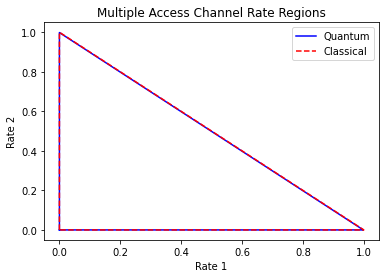


Uniform Priors Rate Region


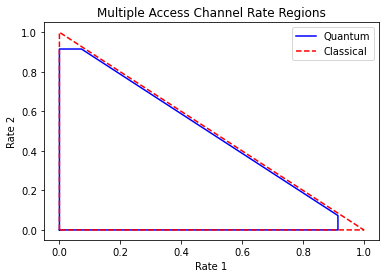

CPU times: user 19.6 s, sys: 212 ms, total: 19.9 s
Wall time: 20 s


In [5]:
%%time

mac_rate_region(local_ansatz, finger_printing_ineq, scan_range_10)

## Quantum Communication Ansatz

iteration :  0 , score :  3.877567287527161
iteration :  25 , score :  6.579773224047831
iteration :  50 , score :  6.850688950284225
iteration :  75 , score :  6.972646884901426
max score :  6.988658192813957
classical bound :  7
rate triple :  (0.9777942789469076, 0.9777880798889291, 0.977794544607054)
priors tuple :  (tensor([0.5, 0.5, 0. ], requires_grad=True), tensor([0.5, 0. , 0.5], requires_grad=True))

Max Rate Region


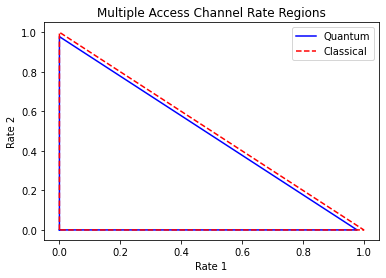


Uniform Priors Rate Region


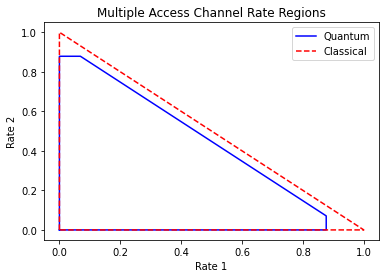

CPU times: user 27.2 s, sys: 270 ms, total: 27.5 s
Wall time: 27.6 s


In [6]:
%%time

mac_rate_region(arb_ansatz, finger_printing_ineq, scan_range_10)

## Entanglement Assisted Classical Ansatz

iteration :  0 , score :  5.269065522365954
iteration :  25 , score :  7.0137147108353926
iteration :  50 , score :  7.376648349747599
iteration :  75 , score :  7.469829224769246
max score :  7.492975671977855
classical bound :  7
rate triple :  (0.5619320523951057, 0.5619265170640748, 0.5619429338452284)
priors tuple :  (tensor([0.5, 0. , 0.5], requires_grad=True), tensor([0.5, 0. , 0.5], requires_grad=True))

Max Rate Region


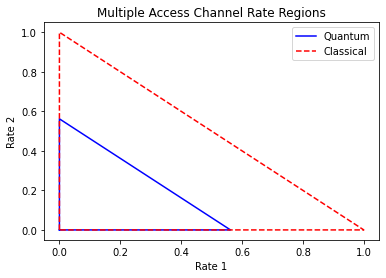


Uniform Priors Rate Region


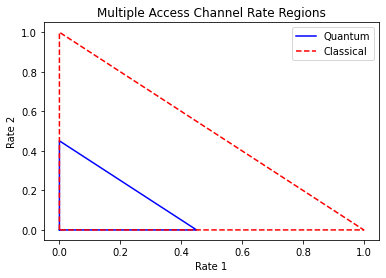

In [7]:
mac_rate_region(ea_ansatz, finger_printing_ineq, scan_range_10)

## Rate Region for the "Perfect" Finger Printing Strategy

In [9]:
perfect_behavior = np.array([
    [1,0,0,0,1,0,0,0,1],[0,1,1,1,0,1,1,1,0]
])

print(np.sum(np.sum(perfect_behavior * finger_printing_ineq)))

perf_rates = []
priors = []
for priors_x in priors_scan_range(10):
    for priors_y in priors_scan_range(10):
        priors.append((priors_x, priors_y))
        perf_rates.append(bisender_mac_mutual_info(perfect_behavior, priors_x, priors_y))

        
perf_rate_sums = [sum(rate_set) for rate_set in perf_rates]
max_perf_rate_sum = max(perf_rate_sums)
max_perf_rate_id = perf_rate_sums.index(max_perf_rate_sum)
max_perf_rate_tuple = perf_rates[max_ea_rate_id]

print("id : ", max_perf_rate_id)
print("rate tuple : ", max_perf_rate_tuple)
print("priors tuple : ", priors[max_perf_rate_id])
plot_rate_region(max_perf_rate_tuple)

uniform_rates = bisender_mac_mutual_info(perfect_behavior, np.ones(3)/3, np.ones(3)/3)

plot_rate_region(uniform_rates)

9


/Users/brian/opt/anaconda3/envs/pennylane-nonlocality-dev/lib/python3.8/site-packages/autoray/autoray.py:84: RuntimeWarning: invalid value encountered in log2
  return get_lib_fn(backend, fn)(*args, **kwargs)


NameError: name 'max_ea_rate_id' is not defined